In [ ]:
from google.colab import drive #存在google drive
import glob
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from keras.layers.convolutional import UpSampling2D, Conv2D 
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.models import load_model
from imageio import imread


drive.mount('/gdrive') #放在跟目錄
a_train = glob.glob('/gdrive/My Drive/beaut_face/*') 
my_test = glob.glob('/gdrive/MyDrive/test/*')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),}
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class Beaut_GANs:

  def build_discriminator():

      def d_layer(layer_input, filters, f_size=(4, 4)):
          d = Conv2D(filters, kernel_size=f_size, 
                    strides=2, padding='same')(layer_input) 
          d = LeakyReLU(alpha=0.2)(d)
          d = InstanceNormalization()(d) 
          return d

      img = Input(shape=(256, 256, 3))

      d1 = d_layer(img, 64)
      d2 = d_layer(d1, 128)
      d3 = d_layer(d2, 256)
      d4 = d_layer(d3, 512)
      validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

      return Model(img, validity)

  def build_generator():
      
      def conv2d(layer_input, filters, f_size=(4, 4)):
          d = Conv2D(filters, kernel_size=f_size, 
                    strides=2, padding='same')(layer_input)
          d = LeakyReLU(alpha=0.2)(d)
          d = InstanceNormalization()(d)
          return d

      def deconv2d(layer_input, skip_input, filters, f_size=(4, 4)):
          u = UpSampling2D(size=(2, 2))(layer_input)
          u = Conv2D(filters, kernel_size=f_size, 
                    strides=1, padding='same')(u)
          u = LeakyReLU(alpha=0.2)(u)
          u = InstanceNormalization()(u)
          u = Concatenate()([u, skip_input])
          return u

      d0 = Input(shape=(256, 256, 3))

      d1 = conv2d(d0, 32)
      d2 = conv2d(d1, 64)
      d3 = conv2d(d2, 128)
      d4 = conv2d(d3, 256)

      u1 = deconv2d(d4, d3, 128)
      u2 = deconv2d(u1, d2, 64)
      u3 = deconv2d(u2, d1, 32)
      u3 = deconv2d(d2, d1, 32)


      u4 = UpSampling2D(size=(2, 2))(u3)
      output_img = Conv2D(3, kernel_size=(4, 4), 
                          strides=1, padding='same', 
                          activation='tanh')(u4)

      return Model(d0, output_img)


  def Training(Train_data=a_train,batch_size = 1,train_count = 2500,
              freeze_genrate = True,
              model_save_path = '/gdrive/My Drive/',
              save_model = True ):

    d_loss_list = []
    g_loss_list = []
    #(16, 16, 1)
    patch = int(256 / 2**4)#16
    disc_patch = (patch, patch, 1)
    #disc_patch
    valid = np.ones((1,) + disc_patch) #ouyput.shape(1,16,16,1)
    fake = np.zeros((1,) + disc_patch) #ouyput.shape(1,16,16,1)

    if freeze_genrate is True:
      d_A.trainable = False;g_A.trainable = True
    else:
      d_A.trainable = True;g_A.trainable = False

    
    for train in range(0, train_count):
        dash = "-" * 15
        print(dash, "Train", train, dash)        
        ida = np.random.randint(0, len(Train_data), batch_size)

        imgs_A = []
      
        for i in ida:
            imgs_A.append((imread(Train_data[i]) - 127.5)/127.5) #127.5
        
        imgs_A = np.array(imgs_A)
        fake_A = g_A.predict(imgs_A)  
        
        dA_loss_real = d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        d_loss = 0.5 * dA_loss
        g_loss = combined.train_on_batch([imgs_A,],[valid,imgs_A,imgs_A,])
            
        dash = "-" * 15
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        if save_model is True:
          if (train+1)%100 == 0:
            d_A.save(model_save_path+"davangogh0.h5")
            g_A.save(model_save_path+"gavangogh.h5")
            combined.save(model_save_path+"combinedvangogh0.h5")
          else:pass
        else:pass



  def Load_weight(Path='/gdrive/My Drive/'):
    from keras.models import load_model
    d_A.load_weights(Path+"davangogh0.h5")
    g_A.load_weights(Path+"gavangogh.h5")
    combined.load_weights(Path+"combinedvangogh0.h5")
  
  def show_predict(test_data=my_test):
    drawbatch = 5
    beaut_batch = []
    drawing_batch = []
    reconstruct_batch = []

    for i in test_data:
        beaut = imread(i)
        beaut_shaped = (beaut - 127.5)/127.5
        beaut_batch.append(beaut)
        fake_drawing_i = g_A.predict(np.array([beaut_shaped]))
        fake_drawing_i = 0.5 * fake_drawing_i + 0.5    
        drawing_batch.append(fake_drawing_i[0])


        
    plt.figure(figsize = (14,10))
    for (i, draw) in enumerate(beaut_batch):   
        plt.subplot(3, drawbatch, i + 1)
        plt.title("Original")
        plt.axis("off")
        plt.imshow(draw)
    for (i, draw) in enumerate(drawing_batch):  
        plt.subplot(3, drawbatch, drawbatch + (i + 1))
        plt.title("Conver")
        plt.axis("off")
        plt.imshow(draw)


In [ ]:
# build model
from keras.optimizers import Adam
op = Adam(0.0002, 0.5)

d_A = Beaut_GANs.build_discriminator()
d_A.compile(loss='mse',optimizer=op,metrics=['accuracy'])
g_A = Beaut_GANs.build_generator() 

In [ ]:
img_A = Input(shape=(256,256,3)) #ginen input shape
fake_A = g_A(img_A)
reconstr_A = g_A(fake_A)
img_A_id = g_A(img_A)
valid_A = d_A(fake_A)

combined = Model(inputs=[img_A],outputs=[valid_A,reconstr_A,img_A_id])
combined.compile(loss=['mse','mae','mae',],loss_weights=[ 1,10,1,],optimizer=op)

In [ ]:
Beaut_GANs.Load_weight()
Beaut_GANs.Training(Train_data=a_train,train_count = 5,save_model = False)

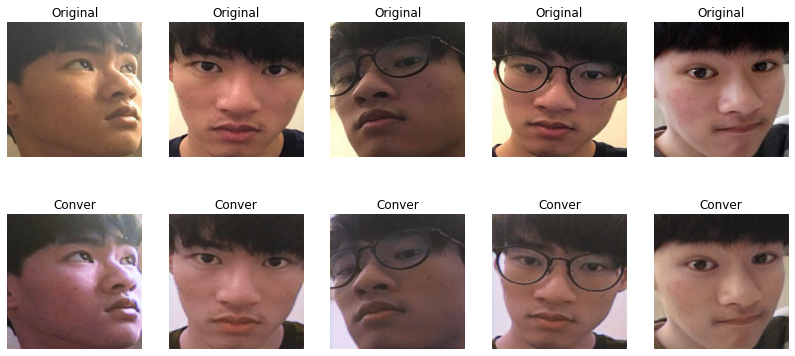

In [ ]:
Beaut_GANs.show_predict(test_data=my_test)